In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [39]:
data = pd.read_csv('E:\ML-Bootcamp\ML\Practical\practical 3 House Price Prediction/yerevan_houses.csv')
test_data = pd.read_csv('E:\ML-Bootcamp\ML\Practical\practical 3 House Price Prediction/test_data.csv')

df = data.drop(['url'], axis=1)
dft = test_data.drop(['url'], axis=1)


df.drop(['region', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
dft.drop(['region', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)


df = df[df['price'] <= 400000]
df = df[df['ceiling_height'] <= 3.2]

for i in df.index:
    if df.at[i, 'floor'] in [1, df.at[i, 'max_floor']]:
        df.at[i, 'floor'] = 1
    else:
        df.at[i, 'floor'] = 0

for i in dft.index:
    if dft.at[i, 'floor'] in [1, dft.at[i, 'max_floor']]:
        dft.at[i, 'floor'] = 1
    else:
        dft.at[i, 'floor'] = 0


X = df[df.columns.difference(['price'])]
y = df['price']

Xt = dft[dft.columns.difference(['price'])]
yt = dft['price']

ohe_columns = ['building_type', 'condition', 'district', 'max_floor', 'street', 'num_rooms']

XX = X[['area', 'ceiling_height', 'num_bathrooms', 'floor']]
XXt = Xt[['area', 'ceiling_height', 'num_bathrooms', 'floor']]

ohencoded = pd.get_dummies(X[ohe_columns].astype(str))
ohencoded_t = pd.get_dummies(Xt[ohe_columns].astype(str))

XX = pd.concat([XX, ohencoded], axis=1)
XXt = pd.concat([XXt, ohencoded_t], axis=1)

add_to_test = []
remove_from_test = []

for column in XX.columns.values:
    if column not in XXt.columns.values:
        add_to_test.append(column)

for column in XXt.columns.values:
    if column not in XX.columns.values:
        remove_from_test.append(column)


for column in add_to_test:
    XXt[column] = np.zeros(XXt.shape[0])

XXt.drop(remove_from_test, axis=1, inplace=True)
XXt = XXt[XX.columns]


In [40]:
np.nanmean(df.price), np.nanmean(dft.price), np.std(y), np.std(yt)

(86144.39690522244, 85422.54716981133, 51703.20150270497, 50491.172132594096)

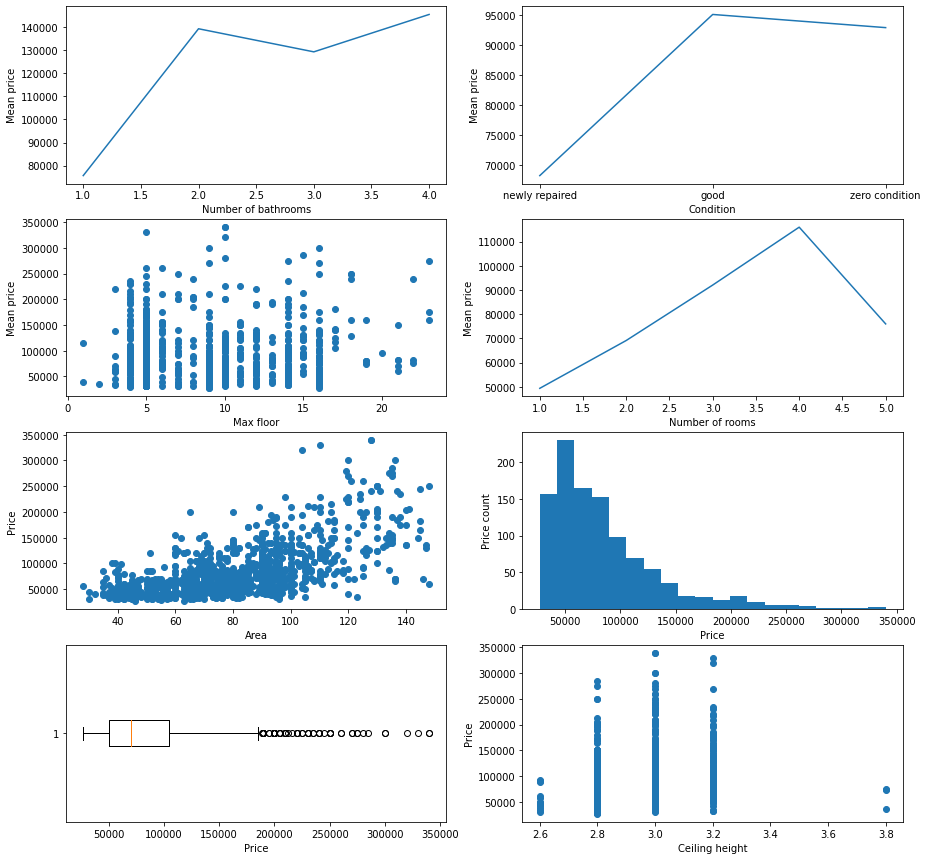

In [41]:
def plot(df):
    fig, axs = plt.subplots(4, 2)
    fig.set_figwidth(15)
    fig.set_figheight(15)

    axs[0][0].plot((np.sort(df.num_bathrooms.unique())), df.groupby('num_bathrooms').price.mean())
    axs[0][0].set_xlabel('Number of bathrooms')
    axs[0][0].set_ylabel('Mean price')

    axs[0][1].plot(df.condition.unique(), df.groupby('condition').price.mean())
    axs[0][1].set_xlabel('Condition')
    axs[0][1].set_ylabel('Mean price')

    axs[1][0].scatter(df.max_floor, df.price)
    axs[1][0].set_xlabel('Max floor')
    axs[1][0].set_ylabel('Mean price')

    axs[1][1].plot(np.sort(df.num_rooms.unique()), df.groupby('num_rooms').price.mean())
    axs[1][1].set_xlabel('Number of rooms')
    axs[1][1].set_ylabel('Mean price')

    axs[2][0].scatter(df.area, df.price)
    axs[2][0].set_xlabel('Area')
    axs[2][0].set_ylabel('Price')

    axs[2][1].hist(df.price, bins=20)
    axs[2][1].set_xlabel('Price')
    axs[2][1].set_ylabel('Price count')

    axs[3][0].boxplot(df.price, vert=False)
    axs[3][0].set_xlabel('Price')


    axs[3][1].scatter(df.ceiling_height, df.price)
    axs[3][1].set_xlabel('Ceiling height')
    axs[3][1].set_ylabel('Price')


plot(dft)

In [5]:
k = 10
train_rmse = []
rmse = []
test_rmse = []

r = Ridge(alpha = 0.5, fit_intercept=False)
kf_cv = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf_cv.split(XX):
    # Train-test split
    X_train, X_test, y_train, y_test = XX.iloc[train_index], XX.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    # Fit
    r.fit(X_train, y_train)
    # Prediction
    y_pred_train = r.predict(X_train)   # Local train   (Ridge)
    y_pred = r.predict(X_test)          # Local test    (Ridge)
    yt_pred = r.predict(XXt)            # Unseen test   (Ridge)

    # RMSE
    train_rmse.append((mean_squared_error(y_train, y_pred_train))**(1/2))
    rmse.append((mean_squared_error(y_test, y_pred))**(1/2))
    test_rmse.append((mean_squared_error(yt, yt_pred))**(1/2))


print('Local train RMSE:', np.array(train_rmse).mean())
print('Local test RMSE: ', np.array(rmse).mean())
print('Unseen test RMSE:', np.array(test_rmse).mean())

Local train RMSE: 21981.163056774025
Local test RMSE:  23374.877975217776
Unseen test RMSE: 23987.796913323178


In [6]:
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import MinMaxScaler

k = 10
train_rmse = []
rmse = []
test_rmse = []

scaler = MinMaxScaler()
r = PoissonRegressor(max_iter = 2000)

kf_cv = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf_cv.split(XX):
    # Train-test split
    X_train, X_test, y_train, y_test = XX.iloc[train_index], XX.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
    norm = scaler.fit(X_train)
    X_train =  pd.DataFrame(norm.transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(norm.transform(X_test), columns = X_test.columns)
    XXt_scaled = pd.DataFrame(norm.transform(XXt), columns = XXt.columns)
    
    # Fit
    r.fit(X_train, y_train)
    # Prediction
    y_pred_train = r.predict(X_train)   # Local train   (Poisson)
    y_pred = r.predict(X_test)          # Local test    (Poisson)
    yt_pred = r.predict(XXt_scaled)     # Unseen test   (Poisson)

    # RMSE
    train_rmse.append((mean_squared_error(y_train, y_pred_train))**(1/2))
    rmse.append((mean_squared_error(y_test, y_pred))**(1/2))
    test_rmse.append((mean_squared_error(yt, yt_pred))**(1/2))


print('Local train RMSE:', np.array(train_rmse).mean())
print('Local test RMSE: ', np.array(rmse).mean())
print('Unseen test RMSE:', np.array(test_rmse).mean())

Local train RMSE: 20058.98708587619
Local test RMSE:  21553.617172648865
Unseen test RMSE: 22077.60217434119


In [7]:
XX.columns.values.shape[0]

399

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor, BernoulliRBM

k = 10
train_rmse = []
rmse = []
test_rmse = []

scaler = MinMaxScaler()
# r = PoissonRegressor(max_iter = 2000)
# r = GaussianNB()
# r = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=None,
#     min_samples_split=10,
#     max_leaf_nodes=15,
#     n_jobs=2
# )
r = MLPRegressor(
    tol=1e-6,
    n_iter_no_change=10,
    max_iter=500,
    learning_rate='adaptive',
    learning_rate_init=0.1,
    warm_start=False)

kf_cv = KFold(n_splits=k, shuffle=True)

# pca = PCA(n_components=100)
# pca.fit(XX)
# print(pca.explained_variance_ratio_)

# XX = pd.DataFrame(pca.transform(XX), index=XX.index)
# XXt = pd.DataFrame(pca.transform(XXt), index=XXt.index)


for train_index, test_index in kf_cv.split(XX):
    # Train-test split
    X_train, X_test, y_train, y_test = XX.iloc[train_index], XX.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
    norm = scaler.fit(X_train)
    X_train =  pd.DataFrame(norm.transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(norm.transform(X_test), columns = X_test.columns)
    XXt_scaled = pd.DataFrame(norm.transform(XXt), columns = XXt.columns)
    
    # Fit
    r.fit(X_train, y_train)
    # Prediction
    y_pred_train = r.predict(X_train)   # Local train   (Poisson)
    y_pred = r.predict(X_test)          # Local test    (Poisson)
    yt_pred = r.predict(XXt_scaled)     # Unseen test   (Poisson)

    # RMSE
    train_rmse.append((mean_squared_error(y_train, y_pred_train))**(1/2))
    rmse.append((mean_squared_error(y_test, y_pred))**(1/2))
    test_rmse.append((mean_squared_error(yt, yt_pred))**(1/2))


print('Local train RMSE:', np.array(train_rmse).mean())
print('Local test RMSE: ', np.array(rmse).mean())
print('Unseen test RMSE:', np.array(test_rmse).mean())

r2_score(yt, yt_pred)

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor


k = 10
train_rmse = []
rmse = []
test_rmse = []

scaler = MinMaxScaler()

pr = PoissonRegressor(max_iter = 2000)

r = AdaBoostRegressor(base_estimator=pr, n_estimators=100)

kf_cv = KFold(n_splits=k, shuffle=True)

pca = PCA(n_components=30)
pca.fit(XX)
# print(pca.explained_variance_ratio_)

XX = pd.DataFrame(pca.transform(XX), index=XX.index)
XXt = pd.DataFrame(pca.transform(XXt), index=XXt.index)

i = 0
for train_index, test_index in kf_cv.split(XX):
    i += 1
    print(i, end=' ')
    # Train-test split
    X_train, X_test, y_train, y_test = XX.iloc[train_index], XX.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
    norm = scaler.fit(X_train)
    X_train =  pd.DataFrame(norm.transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(norm.transform(X_test), columns = X_test.columns)
    XXt_scaled = pd.DataFrame(norm.transform(XXt), columns = XXt.columns)
    
    # Fit
    r.fit(X_train, y_train)
    # Prediction
    y_pred_train = r.predict(X_train)   # Local train   (Poisson)
    y_pred = r.predict(X_test)          # Local test    (Poisson)
    yt_pred = r.predict(XXt_scaled)     # Unseen test   (Poisson)

    # RMSE
    train_rmse.append((mean_squared_error(y_train, y_pred_train))**(1/2))
    rmse.append((mean_squared_error(y_test, y_pred))**(1/2))
    test_rmse.append((mean_squared_error(yt, yt_pred))**(1/2))

print()
print('Local train RMSE:', np.array(train_rmse).mean())
print('Local test RMSE: ', np.array(rmse).mean())
print('Unseen test RMSE:', np.array(test_rmse).mean())

r2_score(yt, yt_pred)

1 2 3 4 5 6 7 8 9 10 
Local train RMSE: 26980.990759472577
Local test RMSE:  27334.51234628489
Unseen test RMSE: 27175.69500464209


0.7230859509435943